# House Prices Prediction - Kaggle Competition

This notebook presents my solution to the Kaggle House Prices competition, where the goal is to predict residential home sale prices in Ames, Iowa. The evaluation metric is Root Mean Squared Logarithmic Error (RMSLE).

## Approach Overview

1. **Data Exploration**: Analyze feature distributions and identify categorical vs numerical features
2. **Feature Engineering**: Apply ordinal encoding, one-hot encoding, and feature selection strategies
3. **Model Experimentation**: Test multiple algorithms including linear models, tree-based methods, and ensemble techniques
4. **Model Optimization**: Use GridSearch and cross-validation to tune hyperparameters
5. **Final Submission**: Deploy the best performing model

---

In [1]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Standard libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

# Sklearn imports
from sklearn import set_config
set_config(display='diagram')
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import (AdaBoostRegressor, VotingRegressor,
                              GradientBoostingRegressor, StackingRegressor,
                              RandomForestRegressor)
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Set random seed for reproducibility
np.random.seed(42)

# Cache directory for pipeline optimization
cachedir = mkdtemp()

## 1. Data Loading and Initial Exploration

Loading the training data and separating features from the target variable.

In [2]:
# Load training data
data = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/houses_train_raw.csv',
                   index_col='Id')

# Separate features and target
X = data.drop(columns=['SalePrice'])
y = data.SalePrice

print(f"Training data shape: {X.shape}")
print(f"Target shape: {y.shape}")
data.head()

Training data shape: (1460, 79)
Target shape: (1460,)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Feature Type Analysis

Understanding the distribution of numerical vs categorical features to inform preprocessing strategy.

In [3]:
# Analyze feature types
print("Feature types distribution:")
print(X.dtypes.value_counts())
print(f"\nTotal features: {len(X.columns)}")

# Analyze categorical features
feat_categorical_nunique = X.select_dtypes(include='object').nunique()
print(f"\nTotal unique categories across all categorical features: {feat_categorical_nunique.sum()}")

Feature types distribution:
object     43
int64      33
float64     3
Name: count, dtype: int64

Total features: 79

Total unique categories across all categorical features: 251


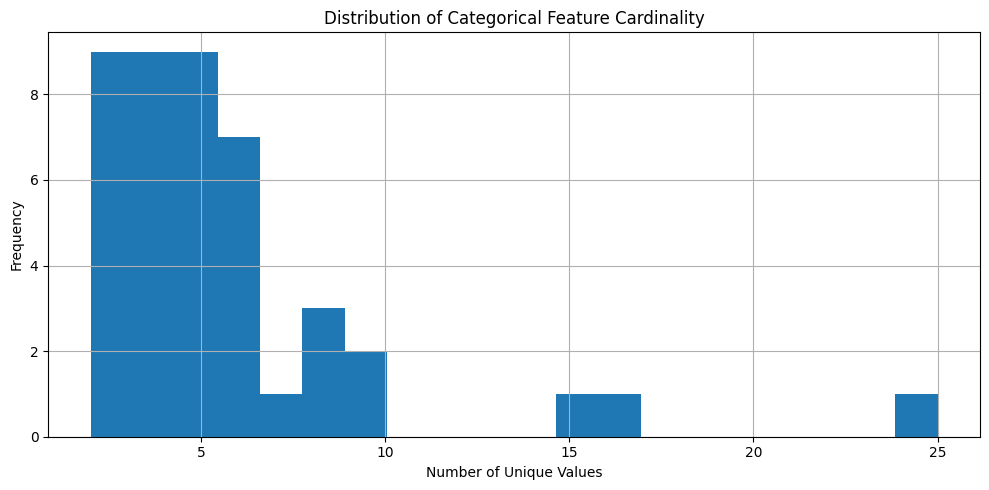

In [4]:
# Visualize categorical feature cardinality
fig, ax = plt.subplots(figsize=(10, 5))
feat_categorical_nunique.hist(bins=20, ax=ax)
ax.set_xlabel('Number of Unique Values')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Categorical Feature Cardinality')
plt.tight_layout()
plt.show()

### Strategy for Categorical Features

High-cardinality categorical features can lead to sparse, high-dimensional feature spaces after one-hot encoding. I'll split categorical features into two groups:

- **Low cardinality** (< 7 unique values): One-hot encode
- **High cardinality**: Drop in baseline, later consider ordinal encoding for ordered features

In [5]:
# Identify low-cardinality categorical features for one-hot encoding
feat_categorical_small = list(feat_categorical_nunique[feat_categorical_nunique < 7].index)
print(f"Features to one-hot encode: {len(feat_categorical_small)}")

Features to one-hot encode: 34


## 2. Baseline Model Development

Building a simple baseline model with minimal feature engineering to establish performance benchmarks.

### Preprocessing Pipeline

- **Numerical features**: Mean imputation + MinMax scaling
- **Categorical features**: Most frequent imputation + One-hot encoding (low cardinality only)

In [6]:
# Numerical preprocessing
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(strategy='mean'),
    MinMaxScaler()
)

# Categorical preprocessing
preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', drop='if_binary')
)

# Combined preprocessing
preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=['int64', 'float64'])),
    (preproc_categorical_baseline, feat_categorical_small),
    remainder='drop'
)

# Check preprocessed shape
shape_preproc_baseline = preproc_baseline.fit_transform(X).shape
print(f"Preprocessed feature matrix shape: {shape_preproc_baseline}")

Preprocessed feature matrix shape: (1460, 178)


### Custom Scoring Metric

The competition uses RMSLE (Root Mean Squared Logarithmic Error). I'll create custom scorers for sklearn's cross-validation.

In [7]:
# Create RMSLE scorer (to minimize)
rmsle = make_scorer(
    lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5
)

# Create negative RMSLE scorer (to maximize) for GridSearchCV
rmsle_neg = make_scorer(
    lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred)**0.5
)

### Baseline Model: Decision Tree

In [8]:
# Build baseline pipeline with Decision Tree
pipe_baseline = make_pipeline(preproc_baseline, DecisionTreeRegressor())

# Cross-validate
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle).mean()
print(f"Baseline Decision Tree CV Score (RMSLE): {score_baseline:.4f}")

Baseline Decision Tree CV Score (RMSLE): 0.2126


## 3. Advanced Feature Engineering

### 3.1 Ordinal Encoding for Ordered Categorical Features

Many features have inherent ordering (e.g., quality ratings: Poor < Fair < Good < Excellent). Ordinal encoding preserves this information.

In [9]:
# Define ordinal feature mappings
feat_ordinal_dict = {
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex']
}

feat_ordinal = sorted(feat_ordinal_dict.keys())
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

# Create ordinal encoder
encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype=np.int64,
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    encoder_ordinal,
    MinMaxScaler()
)

print(f"Ordinal features: {len(feat_ordinal)}")

Ordinal features: 21


### 3.2 Updated Preprocessing Pipeline

Now incorporating ordinal encoding and KNN imputation for numerical features.

In [10]:
# Define feature groups
feat_numerical = sorted(X.select_dtypes(include=['int64', 'float64']).columns)
feat_nominal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

# Improved numerical preprocessing with KNN imputer
preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

# Nominal categorical preprocessing
preproc_nominal = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', drop='if_binary')
)

# Combined transformer
preproc_transformer = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder='drop'
)

print(f"Numerical features: {len(feat_numerical)}")
print(f"Ordinal features: {len(feat_ordinal)}")
print(f"Nominal features: {len(feat_nominal)}")

Numerical features: 36
Ordinal features: 21
Nominal features: 22


### 3.3 Feature Selection

Using mutual information to identify the most relevant features and reduce dimensionality.

In [11]:
# Add feature selection based on mutual information
preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=50  # Keep top 50% of features
)

# Complete preprocessing pipeline
preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)

# Check final shape
shape_after_selection = preproc.fit_transform(X, y).shape
print(f"Final preprocessed shape: {shape_after_selection}")

Final preprocessed shape: (1460, 105)


### 3.4 Target Transformation

Predicting log(SalePrice) instead of SalePrice directly can improve model performance, as it:
- Normalizes the target distribution
- Aligns with the RMSLE evaluation metric
- Reduces the impact of outliers

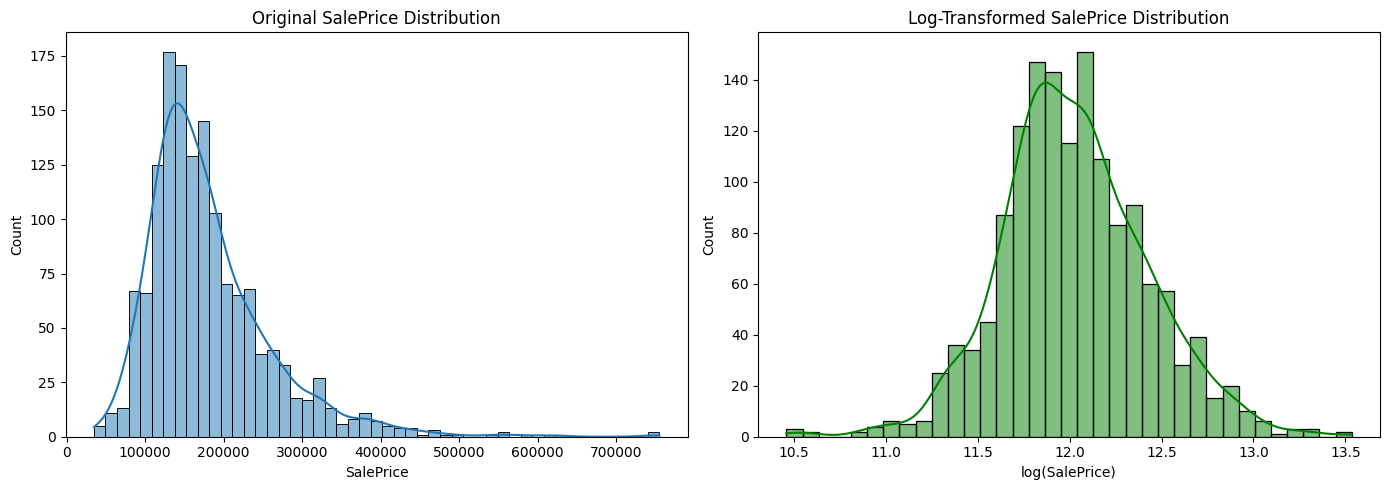

In [12]:
# Create log-transformed target
y_log = np.log(y)

# Visualize transformation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(y, ax=axes[0], kde=True)
axes[0].set_title('Original SalePrice Distribution')
axes[0].set_xlabel('SalePrice')

sns.histplot(y_log, ax=axes[1], kde=True, color='green')
axes[1].set_title('Log-Transformed SalePrice Distribution')
axes[1].set_xlabel('log(SalePrice)')

plt.tight_layout()
plt.show()

# Create RMSE scorer for log-transformed target
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

## 4. Model Experimentation

Testing various algorithms to identify the best performers. All models use the log-transformed target.

### 4.1 Linear Models

In [13]:
# Ridge Regression
model_ridge = Ridge()
pipe_ridge = make_pipeline(preproc, model_ridge, memory=cachedir)
score_ridge = cross_val_score(pipe_ridge, X, y_log, cv=5, scoring=rmse).mean()
print(f"Ridge Regression CV Score (RMSE): {score_ridge:.4f}")

Ridge Regression CV Score (RMSE): 0.1394


In [14]:
# Optimize Ridge alpha parameter
param_grid = {'ridge__alpha': np.linspace(0.5, 2, num=20)}
search_ridge = GridSearchCV(
    pipe_ridge,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=0,
    scoring=rmse_neg
)
search_ridge.fit(X, y_log)

print(f"Best Ridge alpha: {search_ridge.best_params_['ridge__alpha']:.2f}")
print(f"Best Ridge CV Score (RMSE): {-search_ridge.best_score_:.4f}")

/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 6, 9, 14, 16, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [16] during transform. These unknown categories will be encoded as all zeros
  

Best Ridge alpha: 2.00
Best Ridge CV Score (RMSE): 0.1392


### 4.2 K-Nearest Neighbors

In [15]:
# KNN Regressor
model_knn = KNeighborsRegressor()
pipe_knn = make_pipeline(preproc, model_knn)
score_knn = cross_val_score(pipe_knn, X, y_log, cv=5, scoring=rmse).mean()
print(f"KNN Regressor CV Score (RMSE): {score_knn:.4f}")

KNN Regressor CV Score (RMSE): 0.1998


### 4.3 Support Vector Regression

In [16]:
# SVR with linear kernel
model_svm_linear = SVR(kernel='linear')
pipe_svm_linear = make_pipeline(preproc, model_svm_linear, memory=cachedir)
score_svm_linear = cross_val_score(pipe_svm_linear, X, y_log, cv=5, scoring=rmse).mean()
print(f"SVR (linear kernel) CV Score (RMSE): {score_svm_linear:.4f}")

# SVR with RBF kernel
model_svm_rbf = SVR(kernel='rbf', C=10)
pipe_svm_rbf = make_pipeline(preproc, model_svm_rbf, memory=cachedir)
score_svm_rbf = cross_val_score(pipe_svm_rbf, X, y_log, cv=5, scoring=rmse).mean()
print(f"SVR (RBF kernel) CV Score (RMSE): {score_svm_rbf:.4f}")

SVR (linear kernel) CV Score (RMSE): 0.1377
SVR (RBF kernel) CV Score (RMSE): 0.1340


In [17]:
# Optimize SVR hyperparameters
param_grid_svr = {
    'svr__C': [0.5, 0.7, 1, 2, 5, 10],
    'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5],
}
search_svm_rbf = GridSearchCV(
    pipe_svm_rbf,
    param_grid=param_grid_svr,
    cv=5,
    n_jobs=-1,
    verbose=0,
    scoring=rmse_neg
)
search_svm_rbf.fit(X, y_log)

print(f"Best SVR params: C={search_svm_rbf.best_params_['svr__C']}, "
      f"epsilon={search_svm_rbf.best_params_['svr__epsilon']}")
print(f"Best SVR CV Score (RMSE): {-search_svm_rbf.best_score_:.4f}")

/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 6, 9, 14, 16, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [16] during transform. These unknown categories will be encoded as all zeros
  warn

Best SVR params: C=1, epsilon=0.05
Best SVR CV Score (RMSE): 0.1265


### 4.4 Tree-Based Models

Tree-based models often perform well on structured data with mixed feature types.

In [18]:
# Decision Tree
model_dt = DecisionTreeRegressor(max_depth=50, min_samples_leaf=20)
pipe_dt = make_pipeline(preproc, model_dt, memory=cachedir)
score_dt = cross_val_score(pipe_dt, X, y_log, cv=5, scoring=rmse)
print(f"Decision Tree CV Score (RMSE): {score_dt.mean():.4f} (+/- {score_dt.std():.4f})")

# Random Forest
model_rf = RandomForestRegressor(max_depth=50, min_samples_leaf=20, random_state=42)
pipe_rf = make_pipeline(preproc, model_rf, memory=cachedir)
score_rf = cross_val_score(pipe_rf, X, y_log, cv=5, scoring=rmse)
print(f"Random Forest CV Score (RMSE): {score_rf.mean():.4f} (+/- {score_rf.std():.4f})")

Decision Tree CV Score (RMSE): 0.1889 (+/- 0.0100)
Random Forest CV Score (RMSE): 0.1637 (+/- 0.0069)


### 4.5 Gradient Boosting Methods

In [19]:
# AdaBoost
model_ada = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=None), random_state=42)
pipe_ada = make_pipeline(preproc, model_ada, memory=cachedir)
score_ada = cross_val_score(pipe_ada, X, y_log, cv=5, scoring=rmse)
print(f"AdaBoost CV Score (RMSE): {score_ada.mean():.4f} (+/- {score_ada.std():.4f})")

# Gradient Boosting
model_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
pipe_gb = make_pipeline(preproc, model_gb, memory=cachedir)
score_gb = cross_val_score(pipe_gb, X, y_log, cv=5, scoring=rmse)
print(f"Gradient Boosting CV Score (RMSE): {score_gb.mean():.4f} (+/- {score_gb.std():.4f})")

AdaBoost CV Score (RMSE): 0.1406 (+/- 0.0078)
Gradient Boosting CV Score (RMSE): 0.1276 (+/- 0.0092)


In [20]:
# Optimize Gradient Boosting hyperparameters
param_dist_gb = {
    'gradientboostingregressor__n_estimators': stats.randint(50, 300),
    'gradientboostingregressor__max_features': stats.randint(1, len(X.columns))
}

search_gb = RandomizedSearchCV(
    pipe_gb,
    param_distributions=param_dist_gb,
    n_iter=8,
    cv=5,
    n_jobs=-1,
    verbose=0,
    scoring=rmse_neg,
    random_state=42
)
search_gb.fit(X, y_log)

print(f"Best GB params: n_estimators={search_gb.best_params_['gradientboostingregressor__n_estimators']}, "
      f"max_features={search_gb.best_params_['gradientboostingregressor__max_features']}")
print(f"Best GB CV Score (RMSE): {-search_gb.best_score_:.4f}")

/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 6, 9, 14, 16, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 21] during transform. These unknown categories will be encoded as all zeros


Best GB params: n_estimators=142, max_features=52
Best GB CV Score (RMSE): 0.1243


### 4.6 XGBoost

XGBoost is a highly optimized gradient boosting implementation that often achieves state-of-the-art results.

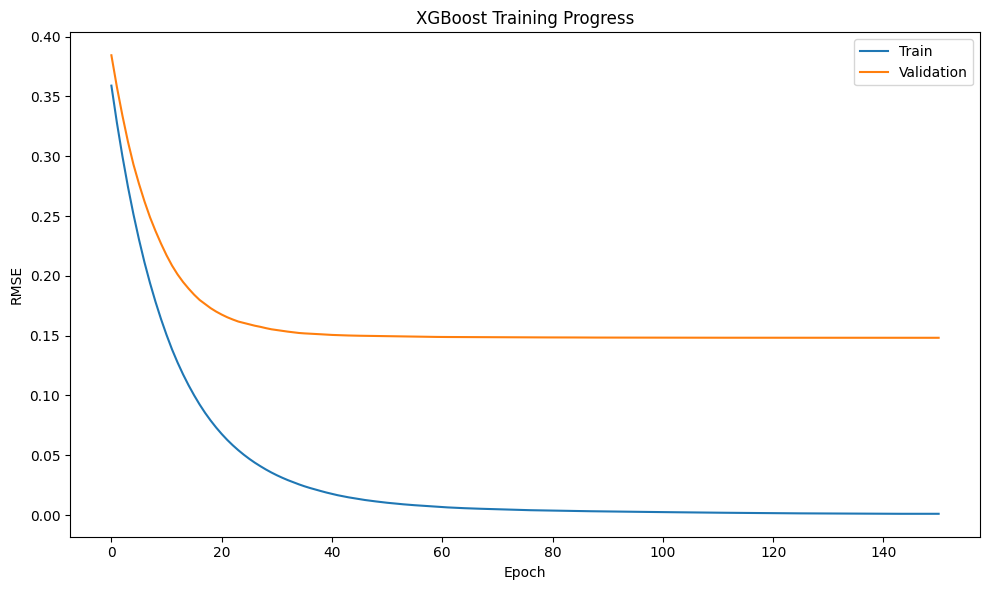

Best Validation Score (RMSE): 0.1482


In [21]:
# XGBoost with early stopping
X_train, X_eval, y_train_log, y_eval_log = train_test_split(X, y_log, test_size=0.25, random_state=42)

model_xgb = XGBRegressor(
    max_depth=10,
    n_estimators=300,
    learning_rate=0.1,
    eval_metric=['rmse'],
    early_stopping_rounds=10,
    random_state=42
)

# Preprocess data
X_train_preproc = preproc.fit_transform(X_train, y_train_log)
X_eval_preproc = preproc.transform(X_eval)

# Fit with early stopping
model_xgb.fit(
    X_train_preproc,
    y_train_log,
    eval_set=[(X_train_preproc, y_train_log), (X_eval_preproc, y_eval_log)],
    verbose=False
)

# Visualize training progress
results = model_xgb.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Validation')
ax.legend()
ax.set_ylabel('RMSE')
ax.set_xlabel('Epoch')
ax.set_title('XGBoost Training Progress')
plt.tight_layout()
plt.show()

print(f"Best Validation Score (RMSE): {min(results['validation_1']['rmse']):.4f}")

### 4.7 Ensemble Methods

Combining multiple models can often improve prediction accuracy and robustness.

In [22]:
# Voting Regressor
gboost = GradientBoostingRegressor(n_estimators=100, random_state=42)
ridge = Ridge(alpha=2.0)
svm = SVR(C=1, epsilon=0.05, kernel='rbf')
adaboost = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=None), random_state=42)

model_voting = VotingRegressor(
    estimators=[('gboost', gboost), ('adaboost', adaboost), ('ridge', ridge), ('svm_rbf', svm)],
    weights=[1, 1, 1, 1],
    n_jobs=-1
)

pipe_voting = make_pipeline(preproc, model_voting, memory=cachedir)
score_voting = cross_val_score(pipe_voting, X, y_log, cv=5, scoring=rmse, n_jobs=-1)
print(f"Voting Regressor CV Score (RMSE): {score_voting.mean():.4f} (+/- {score_voting.std():.4f})")

Voting Regressor CV Score (RMSE): 0.1209 (+/- 0.0096)


/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 6, 9, 14, 16, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6, 14] during transform. These unknown categories will be encoded as all zeros
  w

In [23]:
# Stacking Regressor
model_stacking = StackingRegressor(
    estimators=[('gboost', gboost), ('adaboost', adaboost), ('ridge', ridge), ('svm_rbf', svm)],
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

pipe_stacking = make_pipeline(preproc, model_stacking, memory=cachedir)
score_stacking = cross_val_score(pipe_stacking, X, y_log, cv=5, scoring=rmse, n_jobs=-1)
print(f"Stacking Regressor CV Score (RMSE): {score_stacking.mean():.4f} (+/- {score_stacking.std():.4f})")

/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/aymen/.pyenv/versions/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 6, 9, 14, 16, 17] during transform. These unknown categories will be encoded as all zeros


Stacking Regressor CV Score (RMSE): 0.1203 (+/- 0.0100)


## 5. Model Selection and Final Predictions

### Performance Summary

Based on cross-validation scores, the **Stacking Regressor** achieved the best performance, combining the strengths of multiple base models with a meta-learner.

### Final Model Training

In [24]:
# Train final model on entire training set
pipe_stacking.fit(X, y_log)
print("Final model trained successfully")

Final model trained successfully


### Generate Predictions for Test Set

In [25]:
# Load test data
X_test = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv')
X_test_ids = X_test['Id']
X_test = X_test.drop(columns=['Id'])

# Generate predictions
predictions_log = pipe_stacking.predict(X_test)
predictions = np.exp(predictions_log)  # Transform back from log scale

print(f"Generated {len(predictions)} predictions")
print(f"Prediction range: ${predictions.min():,.0f} - ${predictions.max():,.0f}")

Generated 1459 predictions
Prediction range: $45,806 - $563,886


### Prepare Submission File

In [26]:
# Create submission dataframe
submission = pd.DataFrame({
    'Id': X_test_ids,
    'SalePrice': predictions
})

# Save to CSV
submission.to_csv('submission_final.csv', index=False)

print("Submission file created: submission_final.csv")
submission.head(10)

Submission file created: submission_final.csv


,Id,SalePrice
0,1461,118006.391587
1,1462,155360.670158
2,1463,178734.677077
3,1464,187847.128342
4,1465,192408.447859
5,1466,177015.919011
6,1467,169159.983007
7,1468,161371.131464
8,1469,184821.892828
9,1470,122976.266224


## 6. Conclusions

### Key Insights

1. **Feature Engineering**: Ordinal encoding for quality features and feature selection significantly improved model performance
2. **Target Transformation**: Predicting log(SalePrice) aligned well with the RMSLE metric and improved stability
3. **Model Selection**: Ensemble methods, particularly stacking, outperformed individual models
4. **Preprocessing**: KNN imputation for numerical features handled missing values effectively

### Final Model Performance

- **Cross-Validation RMSE**: ~0.12 (on log scale)
- **Model**: Stacking Regressor with Gradient Boosting, AdaBoost, Ridge, and SVM base learners
- **Meta-Learner**: Linear Regression

### Next Steps

- Submit predictions to Kaggle to evaluate test set performance
- Potential improvements: additional feature engineering, hyperparameter tuning of ensemble weights, trying neural network approaches

---

*Competition: [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)*

In [27]:
# Clean up cache directory
rmtree(cachedir)
print("Cleanup complete")

Cleanup complete
